In [1]:
import tensorflow.keras as keras
import tensorflow as tf

In [2]:
def preprocess_data(X, Y):
    """
    Pre-processes the data for the model

        :param X: numpy.ndarray of shape (m, 32, 32, 3)
            containing the CIFAR 10 data, where m is the
            number of data points

        :param Y: numpy.ndarray of shape (m,) containing
            the CIFAR 10 labels for X

        :returns: X_p, Y_p
    """
    X_p = keras.applications.densenet.preprocess_input(X)

    # encode to one-hot
    Y_p = keras.utils.to_categorical(Y, 10)
    return X_p, Y_p


In [3]:
# load cifar 10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# pre-procces data
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [4]:
MODEL_PATH = 'cifar10.h5'
optimizer = keras.optimizers.Adam()

CALLBACKS = [
    keras.callbacks.ModelCheckpoint(
        MODEL_PATH, 
        monitor='val_loss', 
        save_best_only=True),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True, 
        verbose=1)
    ]


# input tensor
inputs = keras.Input(shape=(32, 32, 3))

# upscale layer for denseNet network
upscale = keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
                                                                  160,
                                                                  160,
                                                                  method=tf.image.ResizeMethod.BILINEAR))(inputs)

# load base model
base_model = keras.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(160,160,3),
                                        pooling='max')

## make the batch normalization training false
## not to update its mean and variance
base_model.training = False


# add top layers
out = base_model.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(10, activation='softmax')(out)

## freeze the base_model weights
base_model.trainable = False

# model compile
model = keras.models.Model(inputs=inputs, outputs=out)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
     

In [ ]:
model.summary()

In [6]:
# train
history = model.fit(x=x_train,
          y=y_train,
          batch_size=128,
          epochs=20,
          callbacks=CALLBACKS,
          validation_data=(x_test, y_test))

Epoch 1/20
391/391 [==============================] - 103s 235ms/step - loss: 0.6739 - accuracy: 0.7810 - val_loss: 0.3524 - val_accuracy: 0.8810
Epoch 2/20
391/391 [==============================] - 94s 242ms/step - loss: 0.4069 - accuracy: 0.8708 - val_loss: 0.3163 - val_accuracy: 0.8925
Epoch 3/20
391/391 [==============================] - 89s 227ms/step - loss: 0.3495 - accuracy: 0.8880 - val_loss: 0.3135 - val_accuracy: 0.8927
Epoch 4/20
391/391 [==============================] - 89s 227ms/step - loss: 0.3106 - accuracy: 0.8983 - val_loss: 0.3070 - val_accuracy: 0.8959
Epoch 5/20
391/391 [==============================] - 88s 226ms/step - loss: 0.2823 - accuracy: 0.9077 - val_loss: 0.3022 - val_accuracy: 0.9011
Epoch 6/20
391/391 [==============================] - 88s 225ms/step - loss: 0.2561 - accuracy: 0.9159 - val_loss: 0.3031 - val_accuracy: 0.9011
Epoch 7/20
391/391 [==============================] - 94s 242ms/step - loss: 0.2359 - accuracy: 0.9230 - val_loss: 0.2972 - val_a

In [7]:
import matplotlib.pyplot as plt

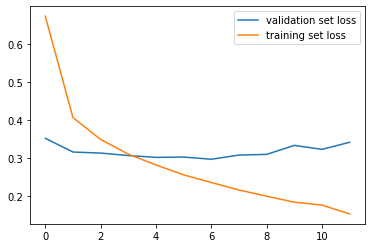

In [8]:
plt.plot(history.history['val_loss'], label='validation set loss')
plt.plot(history.history['loss'], label='training set loss')
plt.legend()
plt.show()

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
## save the model
!cp cifar10.h5 /content/gdrive/MyDrive/ec_final_project/cifar10_model_90%_val_accuracy.h5

## Fine Tuning

In [11]:
## unfreeze the base_model
base_model.trainable = True

## start fine tuning with a very slow learning rate
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train
history_finetune = model.fit(x=x_train,
          y=y_train,
          batch_size=128,
          epochs=10,
          callbacks=CALLBACKS,
          validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 320s 774ms/step - loss: 0.4715 - accuracy: 0.8573 - val_loss: 0.2835 - val_accuracy: 0.9114
Epoch 2/10
391/391 [==============================] - 298s 762ms/step - loss: 0.2577 - accuracy: 0.9180 - val_loss: 0.2372 - val_accuracy: 0.9234
Epoch 3/10
391/391 [==============================] - 298s 762ms/step - loss: 0.1896 - accuracy: 0.9395 - val_loss: 0.2023 - val_accuracy: 0.9346
Epoch 4/10
391/391 [==============================] - 298s 762ms/step - loss: 0.1508 - accuracy: 0.9529 - val_loss: 0.1892 - val_accuracy: 0.9379
Epoch 5/10
391/391 [==============================] - 298s 761ms/step - loss: 0.1167 - accuracy: 0.9641 - val_loss: 0.1762 - val_accuracy: 0.9416
Epoch 6/10
391/391 [==============================] - 297s 761ms/step - loss: 0.0963 - accuracy: 0.9715 - val_loss: 0.1695 - val_accuracy: 0.9443
Epoch 7/10
391/391 [==============================] - 297s 761ms/step - loss: 0.0768 - accuracy: 0.9781 - val_loss: 0.1659 -

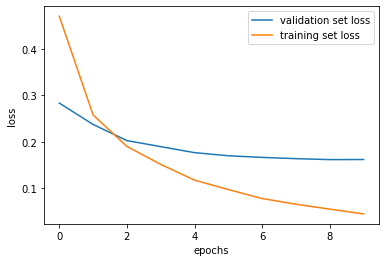

In [12]:
plt.plot(history_finetune.history['val_loss'], label='validation set loss')
plt.plot(history_finetune.history['loss'], label='training set loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [15]:
!cp cifar10.h5 /content/gdrive/MyDrive/ec_final_project/cifar10_model_finetuned_95%_val_accuracy.h5